<center><h1>Using pyFFTW with Classes</h1></center>

---

<center><h3>Author: <a href="https://github.com/marinlauber">Marin Lauber</a></h3></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    import pyfftw
except ModuleNotFoundError:
    print("You will need pyFFTW to run this notebook")

PyFFTW is a high-performance pythonic wrapper to the C-library; FFTW. This library support complex-complex, real-complex, complex-real transform. As opposed to `numpy.fft.fftn()` is requires pre-processing to achieve the best performance.

First, arrays used in the tranform must be aligned in memory, this is where `pyFFTW` is able to make hugh gains in computational time, as the algorithm automaticaly optimises the transform for your machine, with aligned arrays in memory. The library provides and easy function to generate such memeory aligned arrays `pyfftw.empty_aligned(shape, dtype)`, which return a `numpy.array` of a given shape, and data type. The available data type are `float16`, `float32`, `float64`, `complex64`, `complex128`. Remember that complex arrays have twice the amount of data to store, but they are stored in the same number, their precision must be twice of that of the float for the best accuracy.

In [2]:
aligned_array1 = pyfftw.empty_aligned((8,8), dtype='complex64')
type(aligned_array1)

numpy.ndarray

In [3]:
aligned_array2 = pyfftw.empty_aligned((8,8), dtype='complex64')
type(aligned_array2)

numpy.ndarray

There exists different ways of using pyFFTW, the most efficient is to use the `FFTW` class.

```Fortran
CLASS pyfftw.FFTW(input_array, output_array, axes=(-1, ), direction='FFTW_FORWARD', flags=('FFTW_MEASURE', ),  threads=1, planning_timelimit=None)
```
Both the `input_array` and the `output_array` must be aligned in memory. Axes can be specified, by default `pyFFTW` uses the last axis of the array passed. The directio is self-explanatory. flags allow more control on the fft routine. `FFTW_MEASURE` is the default, this means that find an optimized plan by actually computing several FFTs and measuring their execution time. Depending on your machine, this can take some time. The `FFTW_PATIENT` does a simular manoeuvre, but tries more algorithms, which take more time, but result (usually) in faster transform later. `FFTW_EXHAUSTIVE` tests an even broader range of algorithms. You can set a limit to the time `FFTW` spends looking for the best algorithm with the `planning_timelimit` flag.


In [4]:
fft = pyfftw.FFTW(aligned_array1, aligned_array2, direction='FFTW_FORWARD', axes=(-2,-1))
ifft= pyfftw.FFTW(aligned_array2, aligned_array1, direction='FFTW_BACKWARD', axes=(-2,-1))

In [5]:
aligned_array1[:,:] = 1.
np.real(ifft(fft()))

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

We recover the expected array. We also not that the real part of the `aligned_array1` is stored as `float32`, as expected when we specified `complex64` in the array definition.

We also had to set the content of `aligned_array1` to the desired value, of we simply did `aligned_array1 = 1.`, this would have destroyed the aligned array and broken the transform. You can try it, but you will have to restart the kernel.

In [6]:
# aligned_array1 = 1.
# np.real(ifft(fft()))

The result would be this
```Python
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.], 
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)
```

---

### Class

We can now define a class that contains a field and methods that operate fft transforms on this field. This will allows use to look in more details the specifics of `pyFFTW`. This simple `Field` class is simply initialized by passing its size. It the defines storage arrays for a field `u` and transforms as well as a mthod to take the x-direction derivative (`ddx`).

In [7]:
class Field(object):

    def __init__(self, nx, ny):
        '''
        Initializes a field (nx, ny).
        '''
        # grid parameters
        self.nx = nx
        self.ny = ny
        self.nk = self.ny//2+1
        
        # generate gird
        self.x, self.dx = np.linspace(0, 2*np.pi, self.nx,
                                      retstep=True, endpoint=False)
        self.y, self.dy = np.linspace(0, 2*np.pi, self.ny,
                                      retstep=True, endpoint=False)
        
        # wavenumbers
        self.kx = np.fft.fftfreq(self.nx, d=1./self.nx)
        self.ky = np.fft.fftfreq(self.ny, d=1./self.ny)
        
        # iitialise aligned arrays
        self.u = self._empty_real()
        self.uh = self._empty_imag()

        # use FFTW constructor to generate FFT plans
        self.u_to_uh = pyfftw.FFTW(self.u,  self.uh,
                                   direction='FFTW_FORWARD', axes=(-2,-1))
        self.uh_to_u = pyfftw.FFTW(self.uh, self.u,
                                   direction='FFTW_BACKWARD', axes=(-2,-1))


    def init_u(self):
        # initialise self.u with Tatlor-Green vortex, we have to change the content, otherwise
        # we break the FFT routines
        self.u[:,:] = np.sin(self.x) * np.cos(self.y[:, np.newaxis])
        # exact solution for test
        self.dudx =   np.cos(self.x) * np.cos(self.y[:, np.newaxis])


    def _empty_real(self):
        shape = (self.nx, self.ny)
        out = pyfftw.empty_aligned(shape, dtype='float64')
        out.flat[:] = 0.
        return out


    def _empty_imag(self):
        shape = (self.nx, self.nk)
        out = pyfftw.empty_aligned(shape, dtype='complex128')
        out.flat[:] = 0. + 0.j
        return out
       
        
    def ddx(self):
        """
        Take the x-derivative of a periodic field using a spectral method
        """
        # transform
        self.u_to_uh()

        # we have to change the values inside the array, otherwise we break the FFT routines
        self.uh[:,:] = 1j*self.kx[:self.nk]*self.uh[:,:]
        
        # transform back
        self.uh_to_u()


    def display(self, *args):
        # copy otherwise *arg will change content of self.u
        u = np.copy(self.u)
        for arg in args:
            u -= arg
        p = plt.contourf(self.x, self.y, u, levels=31)
        plt.colorbar()
        plt.show()

When we initialise the field, we have all the values set to zero, as expected.

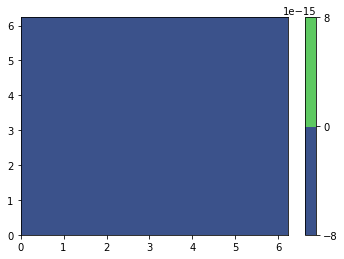

In [8]:
flow = Field(128, 128)
flow.display()

Now we can initialize the field `u` inside our class

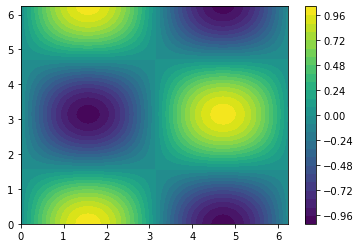

In [9]:
flow.init_u()
flow.display()

now if we call the `ddx` method of our class, we take the derivative, and `u` is now modified.

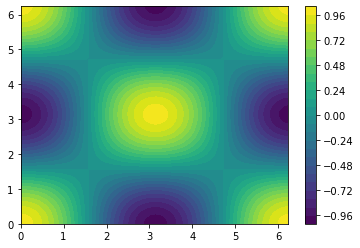

In [10]:
flow.ddx()
flow.display()

We can compare this to the actual true solution, by passing it into the display function

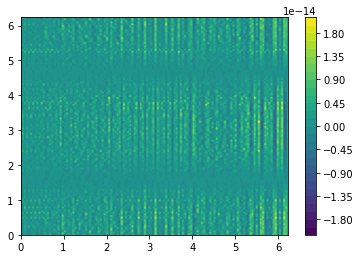

In [11]:
flow.display(flow.dudx)

As expected for spectral methods, there is no errors (only round-off) for this simple harmonic field.

Now we get into some of the specificities of `pyFFTW`. If for a reason we want to use `flow.u`, assigning it to a variable called, say `deriv1`, will actually make both array the same instance

In [12]:
deriv1 = flow.u
print(deriv1 is flow.u)

True


the way around this is to copy the `flow.u` array into the desired array.

In [13]:
deriv2 = np.copy(flow.u)
print(deriv2 is flow.u)

False


The problems that can arrise with `any_array = flow.u` is that any operation on `any_array` will actually modify `flow.u`! This can be very hard to trace and debug!

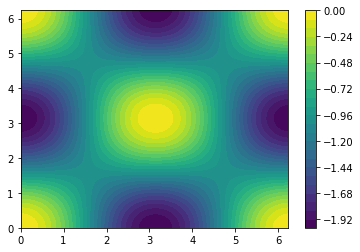

In [14]:
deriv1 += -1
deriv2 += 1
flow.display()

Here we have subtracted 1 to `derive1`, but this has carried-over to `flow.u` (what is displayed with `flow.display()`). Whereas `derive2` has no connections with `flow.u` and thus does not modify its content.